# Experiments with hidden states

Question, is there a better representation of concepts in hidden states?

Setup: we use DPO setup, with a chosen and rejected string. We then generate a set of hidden states, and compare the hidden states of the chosen and rejected string.

Goal: better generalisation of desired behavuour by changing the internal representation of policy rather than directly changing the policy

  - Hypothesis: rejected and chosen hidden states will - on mean - be best representated as rotations from each other
  - alternate: either mean mass diff (linear) or no repr will be better
  - metric: manual generation getting output while maintaining coherency, prediction other sets of hs

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["WANDB_PROJECT"] = "repo-dpo" 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["WANDB_DISABLED"] = "true"

In [3]:
import numpy as np

from datasets import load_dataset
from peft import LoraConfig, get_peft_model
from transformers import AutoTokenizer, AutoModelForCausalLM
from trl import DPOTrainer
from trl import DPOConfig, DPOTrainer

import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Any, Callable, Dict, List, Literal, Optional, Tuple, Union
from jaxtyping import Float
from einops import rearrange, reduce

from pathlib import Path

from reprpo.helpers.adapters import set_adapter
from matplotlib import pyplot as plt
from reprpo import silence
from reprpo.gen import generation_test

from reprpo.trainer import mean_with_attention, symlog, mult_with_attention

from tqdm.auto import tqdm
from reprpo.trainer import collect_hs, ReprPOConfig, ReprPOTrainer, normalize_output, normalize_per
from reprpo.helpers.shypothesis import shypothesis
from datasets import load_dataset

In [68]:
plt.style.use('ggplot')

## Load model

In [4]:
from reprpo.models.load import load_model, print_trainable_parameters
from peft import prepare_model_for_kbit_training
from peft import LoraConfig, get_peft_model
model_name = "NousResearch/Meta-Llama-3-8B-Instruct"
model_name = "microsoft/Phi-3-mini-4k-instruct"

use_gradient_checkpointing = False
model, tokenizer = load_model(model_name, bnb=True) 
# from trl.trainer.utils import peft_module_casting_to_

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
peft_config = LoraConfig(
    target_modules=[
    #     # "qkv_proj", "gate_up_proj", # in
        "down_proj",  "o_proj", # out
    ]
)
from peft import prepare_model_for_kbit_training
from peft import LoraConfig, get_peft_model
from trl.trainer.utils import peft_module_casting_to_bf16
peft_module_casting_to_bf16(model)
adapter_name='ReprPO'
model = prepare_model_for_kbit_training(model, {'use_gradient_checkpointing': use_gradient_checkpointing})
model = get_peft_model(model, peft_config, adapter_name=adapter_name)

## Load adapter

In [6]:
# dpo_adapter_f = './output-dir/dpo/DPO'
# model.load_adapter(dpo_adapter_f, 'DPO')

In [7]:
# # QC model and adapter is coherent
# generation_test(model, tokenizer, max_new_tokens=24, system='no yapping', adapter_names=[None, 'DPO'])

## Load DPO dataset

In [8]:
num_samples = 160

In [9]:
def sample(dataset, N):
    return (dataset
            .shuffle(42)
            .select(range(
            min(len(dataset),
                N)))
    )

dataset = load_dataset('Atsunori/HelpSteer2-DPO')
dataset['train'] = sample(dataset['train'], num_samples)
dataset['validation'] = sample(dataset['validation'], num_samples)
dataset2 = dataset.rename_column('chosen_response', 'chosen').rename_column('rejected_response', 'rejected')
dataset2

DatasetDict({
    train: Dataset({
        features: ['prompt', 'chosen', 'rejected'],
        num_rows: 160
    })
    validation: Dataset({
        features: ['prompt', 'chosen', 'rejected'],
        num_rows: 160
    })
})

In [10]:
def foo(row):
    row['prompt']=row['prompt']+"."
    return row
dataset2 = dataset2.map(foo)

In [11]:
a=np.array([len(l) for l in dataset2['train']['chosen']])
b=np.array([len(l) for l in dataset2['train']['rejected']])
a.mean(), b.mean()

## Collect HS in DPO way

In [12]:
training_args = ReprPOConfig('./output-dir/scratch',
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    bf16=True,
    # tf32=True,
    max_prompt_length=64,
    max_length=128,
    collection_layers=[20,],
    remove_unused_columns=False,

    # optim = "adamw_8bit",
    lr_scheduler_type="constant",
    learning_rate=1e-3,
    gradient_checkpointing=use_gradient_checkpointing,
    # adapter_name="DPO",
 )
reprpo_trainer = ReprPOTrainer(
    model=model,
    ref_model=None,
    args=training_args,
    beta=training_args.beta,
    train_dataset=dataset2["train"],
    eval_dataset=dataset2["validation"],
    tokenizer=tokenizer,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [13]:
# QC get dpo catch
dl = reprpo_trainer.get_train_dataloader()
batch = next(iter(dl))
batch['chosen_input_ids'].shape

torch.Size([2, 128])

In [14]:
from baukit.nethook import recursive_copy, set_requires_grad
from torch import Tensor

In [15]:
# clone this linear, using a clone of the weights and bias
m = model.lm_head
m2 = nn.Linear(m.in_features, m.out_features)
m2.weight = nn.Parameter(m.weight.clone().float())
if m.bias is not None:
    m2.bias = nn.Parameter(m.bias.clone().float())
m2 = m2.cpu()

lm_head = m2
m = None


In [16]:
from reprpo.helpers.svd_decomposer import DualSVDDecomposer, SVDDecomposer


In [17]:
# decomposer = OptimizedSVDDecomposer(lm_head)  # Adjust epsilon as needed
decomposer = DualSVDDecomposer(model.get_input_embeddings().weight.clone().float().cpu(), model.lm_head.weight.clone().float().cpu())

In [18]:
# get batch of hidden states
from reprpo.helpers.torch import clear_mem
from trl.trainer.utils import pad_to_length
from torch import Tensor
from jaxtyping import Float



# @torch.cuda.amp.autocast()
def get_hs(trainer, model, batch, collect_gradient=False):
    model.zero_grad()
    model.train()

    if collect_gradient:
        raise NotImplementedError('Not implemented yet, gradient is None?')
        def make_inputs_require_grad(module, input, output):
            output.requires_grad_(True)
        model.get_input_embeddings().register_forward_hook(make_inputs_require_grad)

    
    (
        chosen_logps,
        rejected_logps,
        chosen_logits,
        rejected_logits,
        _,
        chosen_hs,
        rejected_hs,
        chosen_attn_mask,
        rejected_attn_mask
    ) = trainer.concatenated_forward(trainer.model, batch)

    r = dict(chosen_hs=chosen_hs, rejected_hs=rejected_hs, chosen_logps=chosen_logps, rejected_logps=rejected_logps, chosen_attn_mask=chosen_attn_mask, rejected_attn_mask=rejected_attn_mask,
            chosen_logits=chosen_logits,
            rejected_logits=rejected_logits,
             )


    if collect_gradient:
        chosen_hs.retain_grad()
        rejected_hs.retain_grad()
        loss = (chosen_logps - rejected_logps).mean()
        trainer.accelerator.backward(loss)
        print('chosen_hs.grad', chosen_hs.grad)
        assert chosen_hs.grad is not None, 'FIXME'
        r['chosen_hs_grad'] = chosen_hs.grad
        r['rejected_hs_grad'] = rejected_hs.grad



    # get unembected hs
    r['chosen_unemb'] = model.lm_head(chosen_hs)
    r['rejected_unemb'] = model.lm_head(rejected_hs)

    def get_layer_logps(trainer, hidden_states: Float[Tensor, 'b l t h'], labels: Float[Tensor, 'b t'], log_softmax=True):
        # pad to length
        hidden_states = pad_to_length(hidden_states, trainer.max_length, pad_value=0)
        labels = pad_to_length(labels, trainer.max_length, pad_value=trainer.label_pad_token_id)

        # gather for each layer
        logps = []
        for layer in range(hidden_states.shape[1]):
            all_logps, size_completion = trainer.get_batch_logps(
                hidden_states[:, layer],
                labels,
                label_pad_token_id=trainer.label_pad_token_id,
                log_softmax=log_softmax
                )
            all_logps = all_logps / size_completion
            logps.append(all_logps)
        all_logps = torch.stack(logps, dim=1)
        return all_logps
    
    # get fake logp from unemb_hs
    r['chosen_gthr_logps_unemb'] = get_layer_logps(trainer, r['chosen_unemb'], batch["chosen_labels"])
    r['rejection_gthr_logps_unemb'] = get_layer_logps(trainer, r['rejected_unemb'], batch["rejected_labels"])

    r['chosen_gthr_unemb'] = get_layer_logps(trainer, r['chosen_unemb'], batch["chosen_labels"], log_softmax=False)
    r['rejection_gthr_unemb'] = get_layer_logps(trainer, r['rejected_unemb'], batch["rejected_labels"], log_softmax=False)
    
    # we reuse the function, adding a fake layer dim, and squeezing it out
    r['chosen_gthr_logits'] = get_layer_logps(trainer, chosen_logits[:, None], batch["chosen_labels"], log_softmax=False).squeeze(1)
    r['rejected_gthr_logits'] = get_layer_logps(trainer, rejected_logits[:, None], batch["rejected_labels"], log_softmax=False).squeeze(1)

    # unproject for chosen_hs and rejected_hs
    for k in list(r.keys()):
        if k.endswith('_hs'):
            hs_ov = decomposer(r[k])
            hs_r = r[k] - hs_ov
            r[k+'_r'] = hs_r
            r[k+'_h'] = hs_ov

    r = {k: recursive_copy(v, clone=True, detach=True).detach().cpu() for k, v in r.items()}
    loss = chosen_hs = rejected_hs = chosen_logps = rejected_logps = chosen_logits = rejected_logits = None
    clear_mem(trainer)
    
    return r

In [19]:

n = 0 

dl = reprpo_trainer.get_eval_dataloader()
data = []
for batch in tqdm(dl):
    with reprpo_trainer.null_ref_context():
        r = get_hs(reprpo_trainer, reprpo_trainer.model, batch)
        data.append(r)
        n += r['chosen_hs'].shape[0]
        if n > 64:
            break

# concat
data = {k: torch.cat([d[k] for d in data], dim=0) for k in data[0].keys()}
data['chosen_hs'].shape

  0%|          | 0/80 [00:00<?, ?it/s]

The input hidden states seems to be silently casted in float32, this might be related to the fact you have upcasted embedding or layer norm layers in float32. We will cast back the input in torch.bfloat16.


torch.Size([66, 1, 128, 3072])

In [20]:
clear_mem(reprpo_trainer)


In [21]:
data.keys()

dict_keys(['chosen_hs', 'rejected_hs', 'chosen_logps', 'rejected_logps', 'chosen_attn_mask', 'rejected_attn_mask', 'chosen_logits', 'rejected_logits', 'chosen_unemb', 'rejected_unemb', 'chosen_gthr_logps_unemb', 'rejection_gthr_logps_unemb', 'chosen_gthr_unemb', 'rejection_gthr_unemb', 'chosen_gthr_logits', 'rejected_gthr_logits', 'chosen_hs_r', 'chosen_hs_h', 'rejected_hs_r', 'rejected_hs_h'])

In [22]:
# TODO try getting residual hidden states are removing what might be used by lm_head, e.g. disentangling the part not projected
# model = None
clear_mem(reprpo_trainer)
# reprpo_trainer = None
clear_mem()

In [23]:
# data['chosen_hs']-data['rejected_hs']

In [24]:
# out_dict = dict(
#     data=data,
#     WO=lm_head.weight.clone().detach().cpu(),
#     WE=model.get_input_embeddings().weight.clone().detach().cpu(),
# )
# torch.save(out_dict, '../test/data/dual_svd_decomposer.pt')

### Disentangling hiddenstates into inner and head components

Hypothesis: hidden states contain both "output-directed" information (what will be unembedded to logits) and "internal processing" information. This seems possible because 1) we can unembed the hidden states 2) the hidden states remain fairly constant throughout the layer being additivly transformed by residual connections.

Test: do we get a better correlation with concepts. And does it generalise?

## Get samples

In [25]:
data.keys()

dict_keys(['chosen_hs', 'rejected_hs', 'chosen_logps', 'rejected_logps', 'chosen_attn_mask', 'rejected_attn_mask', 'chosen_logits', 'rejected_logits', 'chosen_unemb', 'rejected_unemb', 'chosen_gthr_logps_unemb', 'rejection_gthr_logps_unemb', 'chosen_gthr_unemb', 'rejection_gthr_unemb', 'chosen_gthr_logits', 'rejected_gthr_logits', 'chosen_hs_r', 'chosen_hs_h', 'rejected_hs_r', 'rejected_hs_h'])

In [26]:
dl = reprpo_trainer.get_eval_dataloader()
batch = next(iter(dl))
print('prompt', batch['prompt'][0])
print('-'*80)
print('chosen\n', batch['chosen'][0])
print('-'*80)
print('rejected\n', batch['rejected'][0])

prompt give me some of the literature survey of phishing websites using data mining.
--------------------------------------------------------------------------------
chosen
 Phishing is a type of cyber attack that involves creating fake websites to steal personal information, such as login credentials and credit card numbers. Data mining is a technique used to analyze large amounts of data to identify patterns and trends. It can be used to detect phishing websites by analyzing various features, such as URL, content, and user behavior.

Here are some recent literature surveys on phishing website detection using data mining:

1. "A Survey on Phishing Website Detection Using Data Mining Techniques" by M. Mohana Priya and P. Srividya (International Journal of Trend in Research and Development (IJTRD), Vol. 4, Issue 11, November 2017). This survey paper provides an overview of various data mining techniques used for phishing website detection, including decision trees, Bayesian networks, ar

In [27]:
concatenated_batch = reprpo_trainer.concatenated_inputs(
    batch,
    is_encoder_decoder=reprpo_trainer.is_encoder_decoder,
    is_vision_model=reprpo_trainer.is_vision_model,
    label_pad_token_id=reprpo_trainer.label_pad_token_id,
    padding_value=reprpo_trainer.padding_value,
    device=reprpo_trainer.accelerator.device,
    max_length=reprpo_trainer.max_length
)

b0_tokens = concatenated_batch['concatenated_input_ids'][0]
print(b0_tokens, b0_tokens.shape, reprpo_trainer.max_length)
print(tokenizer.decode(b0_tokens, skip_special_tokens=False))

tensor([    1,  2367,   592,   777,   310,   278, 12845, 18994,   310,  1374,
        14424, 28007,   773,   848,  1375,   292, 29889,  4819, 14424,   338,
          263,  1134,   310,  5094,   495,  5337,   393, 20789,  4969, 25713,
        28007,   304,  1886,   284,  7333,  2472, 29892,  1316,   408,  6464,
        16140,   322, 16200,  5881,  3694, 29889,  3630,  1375,   292,   338,
          263, 11043,  1304,   304, 27599,  2919, 26999,   310,   848,   304,
        12439, 15038,   322,   534,  1975, 29889,   739,   508,   367,  1304,
          304,  6459,  1374, 14424, 28007,   491, 29537,   292,  5164,  5680,
        29892, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
        32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
        32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
        32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
        32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000],

## Plot decomposed

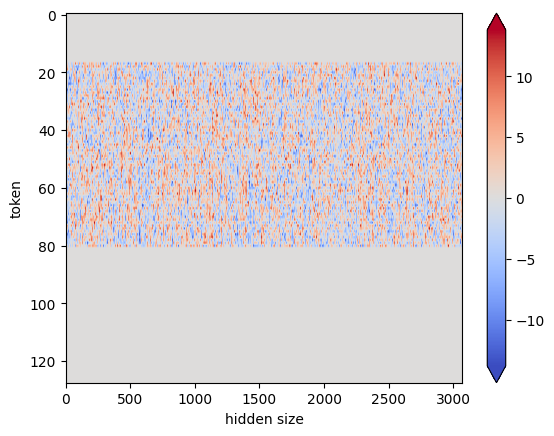

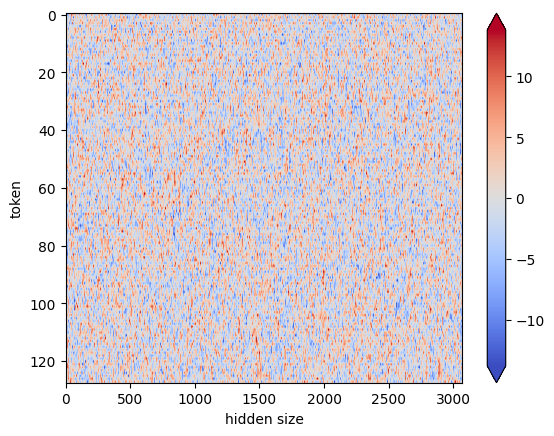

In [62]:
# plot decompose
C = data['chosen_hs_r'].float() # we could also consider unembedding them, whith the lm head, this might make them more interpretable, but also a bit large
R = data['rejected_hs_r'].float()

CA = data['chosen_attn_mask']
RA = data['rejected_attn_mask']
A2 = CA * RA # use both attn masks when comparing?

def decom(x):
    return x - decomposer(x)

x = decom(C)-decom(R)

# x = decom(C-R)

def imshow(x):
    x = symlog(x)
    v = x.abs().max()
    v = x.abs().quantile(0.9)
    plt.imshow(x, cmap='coolwarm', aspect='auto', vmin=-v, vmax=v)
    plt.colorbar(extend='both')
    plt.xlabel('hidden size')
    plt.ylabel('token')

x3 = mult_with_attention(x, A2)
imshow(x3[0,0])
plt.show()

x2 = mean_with_attention(x, A2, 0)[0]
imshow(x2)

## Ignore top 100 logits

In [128]:
hs = C


def get_unlikely_hs(hs, WO, K=100):
    """Remove top K likely tokens from hidden states"""
    psuedo_logits = hs @ WO.T
    softmax_probs = torch.softmax(psuedo_logits, dim=-1)
    top_k_indices = torch.topk(softmax_probs, K).indices

    # Create a mask for the unlikely tokens
    mask = torch.ones_like(softmax_probs, dtype=torch.bool)  # [batch, tokens, vocab_size]
    # mask.scatter_(-1, top_k_indices, False)

    # Project the mask back to hidden state space
    projected_mask = mask.float() @ WO  # [batch, tokens, hidden_dim]
    projected_mask = projected_mask / projected_mask.norm(dim=-1, keepdim=True)
    # print(projected_mask)

    unlikely_hs = hs * projected_mask
    return unlikely_hs

WO = lm_head.weight.clone().detach().cpu()
hs_ul = get_unlikely_hs(hs, WO, K=10)

    

Norm of unlikely hidden states: 1.6386914253234863
Norm of total hidden states: 91.79115295410156
Proportion of total: 0.017852390184998512


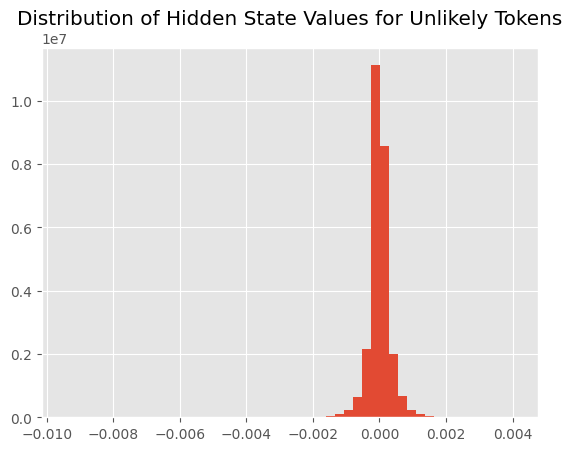

In [129]:
# Analyze the unlikely hidden state values
unlikely_norm = torch.norm(hs_ul)
total_norm = torch.norm(hs)

print(f"Norm of unlikely hidden states: {unlikely_norm}")
print(f"Norm of total hidden states: {total_norm}")
print(f"Proportion of total: {unlikely_norm / total_norm}")

# Look at the distribution of these hidden state values
plt.hist(hs_ul.detach().cpu().numpy().flatten(), bins=50)
plt.title("Distribution of Hidden State Values for Unlikely Tokens")
plt.show()

In [145]:
def analyze_unlikely_hidden_states(hidden_states, WO, k=100):
    # hidden_states: [batch, tokens, hidden_dim]
    # lm_head.weight: [vocab_size, hidden_dim]
    
    logits = hidden_states @ WO.T  # [batch, tokens, vocab_size]
    softmax_probs = torch.softmax(logits, dim=-1)
    
    # Get the k most likely tokens
    _, top_k_indices = torch.topk(softmax_probs, k, largest=True, dim=-1)  # [batch, tokens, k]
    
    # Create a mask for the unlikely tokens
    mask = torch.ones_like(softmax_probs)  # [batch, tokens, vocab_size]
    mask.scatter_(-1, top_k_indices, 0)
    mask = mask.float()
    print('mask', mask.mean())
    
    # Project the mask back to hidden state space
    projected_mask = mask @ WO # [batch, tokens, hidden_dim]
    
    # Normalize the projected mask to preserve norm
    # proj_mask_norm = torch.norm(projected_mask, dim=(-1,), p=1, keepdim=True)
    proj_mask_norm = torch.sqrt(projected_mask**2+1e-10)
    # total_norm = torch.norm(WO, dim=0, keepdim=True)
    # projected_mask = projected_mask * (total_norm / proj_mask_norm)
    projected_mask = projected_mask / proj_mask_norm
    
    # Extract hidden state values corresponding to unlikely tokens
    unlikely_hidden = hidden_states * projected_mask
    
    # Analyze the unlikely hidden state values
    unlikely_norm = torch.norm(unlikely_hidden)
    total_norm = torch.norm(hidden_states)
    
    print(f"Norm of unlikely hidden states: {unlikely_norm}")
    print(f"Norm of original hidden states: {total_norm}")
    print(f"Proportion of total: {unlikely_norm / total_norm}")
    
    
   # Sanity check
    if k == 0:
        print("\tSanity check: Norms should be equal when not masking (k=0)")
        print(f"\tDifference in norms: {torch.abs(unlikely_norm - total_norm)}")
    return unlikely_hidden, projected_mask

# Test with no masking
no_mask_hidden, no_mask_proj = analyze_unlikely_hidden_states(hs, WO, k=0)

# Test with some masking
unlikely_hidden, projected_mask = analyze_unlikely_hidden_states(hs,WO, k=4000)

# # Test with maximum masking
# max_mask_hidden, max_mask_proj = analyze_unlikely_hidden_states(hs, WO, k=lm_head.weight.shape[0]-1)

# note this seems too slow? what about in cuda?

mask tensor(1.)
Norm of unlikely hidden states: 91.79115295410156
Norm of original hidden states: 91.79115295410156
Proportion of total: 1.0
	Sanity check: Norms should be equal when not masking (k=0)
	Difference in norms: 0.0
mask tensor(0.9063)
Norm of unlikely hidden states: 91.79114532470703
Norm of original hidden states: 91.79115295410156
Proportion of total: 0.9999999403953552


## Extract variables

In [37]:
# get some data samples
layer = 0
C = data['chosen_hs_r'].float() # we could also consider unembedding them, whith the lm head, this might make them more interpretable, but also a bit large
R = data['rejected_hs_r'].float()

# C /= C.norm(dim=-1, keepdim=True)
# R /= R.norm(dim=-1, keepdim=True)

C = C - decomposer(C.cpu())
R = R - decomposer(R.cpu())

CA = data['chosen_attn_mask']
RA = data['rejected_attn_mask']

M = 100
A2 = CA * RA # use both attn masks when comparing?

# # choose layer, mean over tokens
# C = mult_with_attention(C, A2)[:M, layer]
# C = reduce(C, 'b t h -> b h', 'mean')
# R = mult_with_attention(R, A2)[:M, layer]
# R = reduce(R, 'b t h -> b h', 'mean')

# choose layer, mean over tokens
C = mean_with_attention(C, A2, 2)[:M, layer]
R = mean_with_attention(R, A2, 2)[:M, layer]


# compare two unrelated sets of samples, that way we have ones that should show the difference and ones that shouldn't show the difference we arel ooking for
n = len(C)//2
C1 = C[:n] # chosen pair 1
R1 = R[:n] # rejected pair 1
C2 = C[n:] # chosen, pair 2
R2 = R[n:] # rejected pair 2


# now we choose what to test correlations with. At first I tried the logprobs but they have been through a softmax which makes them relative and hard to compare to the hidden states
# so instead we are going to try the hidden states values that corresponded to the 

# logratios = data['chosen_logps'] - data['rejected_logps'] # the logp is the log probability (mean per token) of this response, logratios is the log ratio of probs, this should be correlated with the direction we are seeking in the hidden states

logratios = (data['chosen_gthr_logits']- data['rejected_gthr_logits'])
# logratios = data['chosen_gthr_unemb'][:, layer] - data['rejection_gthr_unemb'][:, layer]
logratios = logratios.float()

# we can use this to check the null hypothesis, as the `roll` operation mixes up the batch dimension, so they are unrelated
# logratios_unrelated = logratios.roll(1, 0)

logratios1 = logratios[:n]
logratios2 = logratios[n:]
logratios2.shape

torch.Size([33])

## Hypothesis

#### Is it significant?

is the red line outside the distribution of null correlations?


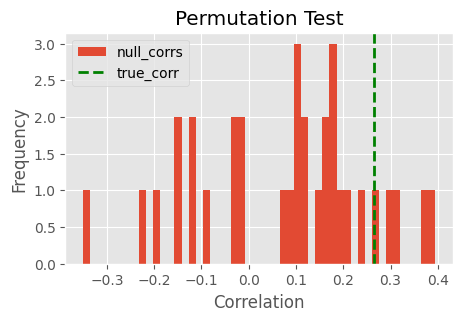

H		pᵥₐₗᵤₑ < 0.1
∴		0.206 < 0.1 ❌ [Δ = 0.106]



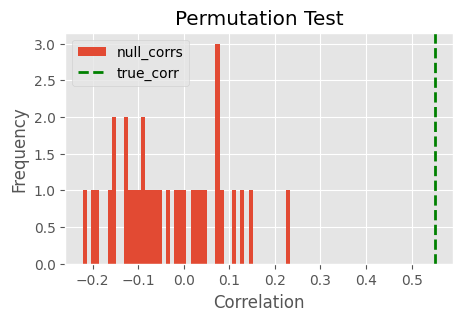

H		pᵥₐₗᵤₑ < 0.1
∴		0.029 < 0.1 ✅ [Δ = -0.071]



In [74]:
def permutation_test(C, R, logratios, n_permutations=100):

    n_permutations = min(n_permutations, len(logratios))

    true_corr = np.corrcoef(
        torch.norm(C - R, dim=-1, p=2), 
        logratios)[0, 1]
    
    null_corrs = []
    for _ in range(n_permutations):
        perm_logratios = logratios[torch.randperm(len(logratios))]
        null_corrs.append(np.corrcoef(torch.norm(C - R, dim=-1, p=2), perm_logratios)[0, 1])
    
    plt.figure(figsize=(5, 3))
    plt.hist(null_corrs, bins=50, label='null_corrs')
    plt.axvline(true_corr, color='g', linestyle='dashed', linewidth=2, label='true_corr')
    plt.title('Permutation Test')
    plt.xlabel('Correlation')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()
    
    p_value = (np.sum(np.abs(null_corrs) >= np.abs(true_corr)) + 1) / (n_permutations + 1)
    shypothesis('p_value<0.10', locals())

print('is the red line outside the distribution of null correlations?')
permutation_test(C1, R1, logratios1)
permutation_test(C2, R2, logratios2)
# FAIL

### Metrics correlations

In [99]:
import torch
import torch.nn.functional as F
import numpy as np

def corr(x, y):
    d = torch.stack([x, y], dim=0)
    return torch.corrcoef(d)[0, 1].item()

def angle_similarity_correlation(C, R, logratios):
    C_norm = F.normalize(C, p=2, dim=-1)
    R_norm = F.normalize(R, p=2, dim=-1)
    dist = torch.acos(torch.clamp(torch.sum(C_norm * R_norm, dim=-1), -1.0, 1.0))
    return corr(dist, logratios)

def norm_difference_correlation(C, R, logratios):
    dist = torch.norm(C, dim=-1) - torch.norm(R, dim=-1)
    return corr(dist, logratios)

def magnitude_correlation(C, R, logratios):
    dist = torch.abs(C - R).mean(dim=-1)
    return corr(dist, logratios)

def inner_product_correlation(C, R, logratios):
    dist = torch.sum(C * R, dim=-1)
    return corr(dist, logratios)

# Usage
def run_all_tests(C1, R1, C2, R2, logratios1, logratios2):
    tests = [
        angle_similarity_correlation,
        norm_difference_correlation,
        magnitude_correlation,
        inner_product_correlation
    ]
    
    for test in tests:
        print(f"\nTesting **{test.__name__}**:")
        c111 = test(C1, R1, logratios1) * 1e-12
        c222 = test(C2, R2, logratios2)
        c112 = test(C1, R1, logratios1.roll(1, 0))
        c221 = test(C2, R2, logratios2.roll(1, 0))
        
        print('Similarity of related ones should be higher')
        shypothesis('(c111) > (c112)', variables=locals(), verbose=1)
        shypothesis('(c222) > (c221)', variables=locals(), verbose=1)
        # Uncomment these if you want to test across different pairs
        shypothesis('c111 > c221', variables=locals(), verbose=1)
        shypothesis('c222 > c112', variables=locals(), verbose=1)

# Run all tests
run_all_tests(C1, R1, C2, R2, logratios1, logratios2)


Testing **angle_similarity_correlation**:
Similarity of related ones should be higher
H		c₁₁₁ > c₁₁₂
		0.0 > -0.314
∴		 0.0 > -0.314 ✅ [Δ = 0.314]

H		c₂₂₂ > c₂₂₁
		0.408 > -0.350
∴		 0.408 > -0.350 ✅ [Δ = 0.758]

H		c₁₁₁ > c₂₂₁
		0.0 > -0.350
∴		 0.0 > -0.350 ✅ [Δ = 0.350]

H		c₂₂₂ > c₁₁₂
		0.408 > -0.314
∴		 0.408 > -0.314 ✅ [Δ = 0.722]


Testing **norm_difference_correlation**:
Similarity of related ones should be higher
H		c₁₁₁ > c₁₁₂
		0.0 > -0.237
∴		 0.0 > -0.237 ✅ [Δ = 0.237]

H		c₂₂₂ > c₂₂₁
		0.664 > -0.104
∴		 0.664 > -0.104 ✅ [Δ = 0.768]

H		c₁₁₁ > c₂₂₁
		0.0 > -0.104
∴		 0.0 > -0.104 ✅ [Δ = 0.104]

H		c₂₂₂ > c₁₁₂
		0.664 > -0.237
∴		 0.664 > -0.237 ✅ [Δ = 0.901]


Testing **magnitude_correlation**:
Similarity of related ones should be higher
H		c₁₁₁ > c₁₁₂
		0.0 > -0.098
∴		 0.0 > -0.098 ✅ [Δ = 0.098]

H		c₂₂₂ > c₂₂₁
		0.536 > -0.397
∴		 0.536 > -0.397 ✅ [Δ = 0.933]

H		c₁₁₁ > c₂₂₁
		0.0 > -0.397
∴		 0.0 > -0.397 ✅ [Δ = 0.397]

H		c₂₂₂ > c₁₁₂
		0.536 > -0.098
∴		 0.536 > -

In [111]:
@torch.no_grad()
def rotation_test(C, R, logratios):
    def optimal_rotation(A, B):

        corr_matrix = torch.mm(A.t(), B)
        Q, _ = torch.linalg.qr(corr_matrix)
        return Q
    
    def optimal_rotation(A, B):
        corr_matrix = torch.mm(A.t(), B)
        U, _, V = torch.linalg.svd(corr_matrix)
        return torch.mm(U, V.t())
    
    R_opt = optimal_rotation(C, R)
    R_rotated = torch.matmul(R, R_opt.t())
    
    a = C - R
    b = C - R_rotated

    # a -= a.mean(dim=-1, keepdim=True)
    # b -= b.mean(dim=-1, keepdim=True)
    # a /= torch.norm(a, dim=0, p=2, keepdim=True)
    # b /= torch.norm(b, dim=0, p=2, keepdim=True)
    a = F.normalize(a, p=2, dim=-1)
    b = F.normalize(b, p=2, dim=-1)

    # original_diff = torch.norm(a, p=2)
    # rotated_diff = torch.norm(b, p=2)
    
    # print(f"Original norm difference: {original_diff}")
    # print(f"Rotated norm difference: {rotated_diff}")
    # print(f"Improvement: {(original_diff - rotated_diff) / original_diff * 100:.2f}%")
    
    c = np.abs(np.corrcoef(torch.norm(a, dim=-1, p=2), logratios)[0, 1])
    r = np.abs(np.corrcoef(torch.norm(b, dim=-1, p=2), logratios)[0, 1])
    print(f"Correlation before rotation: {c:.2f}")
    print(f"Correlation after rotation: {r:.2f}")
    print(f"Improvement: {(r - c) / c * 100:.2f}%")
    print()
    return c, r

print('Can we remove the correlation with a rotation? WIP')
c, c_rot = rotation_test(C1, R1, logratios1)
shypothesis('c < c_rot', locals(), verbose=1)
c, c_rot = rotation_test(C2, R2, logratios2)
shypothesis('c < c_rot', locals(), verbose=1)

c, c_rot = rotation_test(C1, R1, logratios1.roll(1, 0))
shypothesis('c > c_rot', locals(), verbose=1)

c, c_rot = rotation_test(C2, R2, logratios2.roll(1, 0))
shypothesis('c > c_rot', locals(), verbose=1)

c, c_rot = rotation_test(C2, R2, logratios1.roll(1, 0))
shypothesis('c > c_rot', locals(), verbose=1)

# R_opt, R_rotated = rotation_test(C2, R2, logratios2.roll(1, 0))
# R_opt, R_rotated = rotation_test(C1, R1, logratios1.roll(1, 0))
# R_opt, R_rotated = rotation_test(C2, R2, logratios1)
# R_opt, R_rotated = rotation_test(C1, R1, logratios2)

Can we remove the correlation with a rotation?
Correlation before rotation: 0.27
Correlation after rotation: 0.16
Improvement: -40.99%

H		c < cᵣₒₜ
		0.266 < 0.157
∴		 0.266 < 0.157 ❌ [Δ = 0.109]

Correlation before rotation: 0.55
Correlation after rotation: 0.03
Improvement: -94.77%

H		c < cᵣₒₜ
		0.552 < 0.029
∴		 0.552 < 0.029 ❌ [Δ = 0.523]

Correlation before rotation: 0.09
Correlation after rotation: 0.24
Improvement: 156.14%

H		c > cᵣₒₜ
		0.095 > 0.243
∴		 0.095 > 0.243 ❌ [Δ = -0.148]

Correlation before rotation: 0.40
Correlation after rotation: 0.12
Improvement: -70.61%

H		c > cᵣₒₜ
		0.395 > 0.116
∴		 0.395 > 0.116 ✅ [Δ = 0.279]

Correlation before rotation: 0.01
Correlation after rotation: 0.01
Improvement: -27.29%

H		c > cᵣₒₜ
		0.011 > 0.008
∴		 0.011 > 0.008 ✅ [Δ = 0.003]

